In [18]:
import pandas as pd
import polars as pl
import numpy as np
import bottleneck
import matplotlib.pyplot as plt
from riskmatrix.alpha.alpha101 import compute_alpha101

In [2]:
FILTER_SYMBOLS = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'DOGEUSDT', 'BNBUSDT', 'ADAUSDT', '1000SHIBUSDT', 'MATICUSDT', 'AVAXUSDT', 'ETCUSDT', 'LTCUSDT', 'LINKUSDT', 'DOTUSDT', 'FTMUSDT', '1000PEPEUSDT', 'GMTUSDT', 'BCHUSDT', 'FILUSDT', 'SANDUSDT', 'NEARUSDT', 'EOSUSDT', 'AXSUSDT', 'GALAUSDT', 'APEUSDT', 'ATOMUSDT', 'MANAUSDT', 'APTUSDT', 'OPUSDT', 'TRXUSDT', 'DYDXUSDT', 'ORDIUSDT', 'CHZUSDT', 'TRBUSDT', 'WIFUSDT', 'CRVUSDT', 'ARBUSDT', 'UNIUSDT', 'SUIUSDT', 'WLDUSDT', 'AAVEUSDT', 'WAVESUSDT', 'PEOPLEUSDT', 'SUSHIUSDT', 'MASKUSDT', 'RUNEUSDT', 'XLMUSDT', 'THETAUSDT', 'INJUSDT', 'LRCUSDT', 'CFXUSDT', 'VETUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ZILUSDT', 'SXPUSDT', 'XTZUSDT', 'GRTUSDT', 'LINAUSDT', 'MKRUSDT', 'TIAUSDT', 'STORJUSDT', 'UNFIUSDT', '1000BONKUSDT', 'NOTUSDT', 'ENJUSDT', 'NEOUSDT', 'EGLDUSDT', 'FETUSDT', '1INCHUSDT', '1000LUNCUSDT', 'STXUSDT', 'COMPUSDT', 'YFIUSDT', 'ONEUSDT', 'KNCUSDT', 'LDOUSDT', '1000SATSUSDT', 'SNXUSDT', 'ZECUSDT', 'ENSUSDT', 'OMGUSDT', 'BOMEUSDT', 'SEIUSDT', 'MTLUSDT', 'BLZUSDT', 'REEFUSDT', 'CHRUSDT', 'BAKEUSDT', 'KAVAUSDT', '1000FLOKIUSDT', 'ENAUSDT', 'RSRUSDT', 'XMRUSDT', 'RNDRUSDT', 'RLCUSDT', 'OGNUSDT', 'JASMYUSDT', 'BELUSDT', 'OCEANUSDT']

In [3]:
def compute_past_close_return(df: pl.DataFrame, N: int):
    for i in range(N):
        df = df.with_columns(
            ((pl.col("close") / pl.col("close").shift(i+1) - 1) * 100)
            .over("symbol")  # Applying the function over each symbol group
            .alias(f'past_close_return_{i+1}')
        )
    df = df.with_columns(returns=pl.col('past_close_return_1'))
    return df

In [4]:
def read_binance_data(filename, filter_symbols):
    # read parquet file with pandas
    df = pl.read_parquet(filename)
    df = df.with_columns(vwap=pl.col('quote_volume')/pl.col('volume'))
    df = df.with_columns(open_time=pl.from_epoch(pl.col("open_time"), time_unit="ms").cast(pl.Datetime('ms')))
    df = df.with_columns(close_time=pl.from_epoch(pl.col("close_time"), time_unit="ms").cast(pl.Datetime('ms')))

    # filter symbols ending in USDT
    df = df.filter(pl.col("symbol").is_in(filter_symbols))
    # FILTER_SYMBOLS = df[['symbol', 'quote_volume']].groupby('symbol').sum().sort_values('quote_volume', ascending=False).index.to_list()[:100]
    df = df.sort(by=['symbol', 'open_time'])
    return df


In [5]:
def compute_features(filename, filter_symbols):
    df = read_binance_data('../scratch/dp/data/all_data_1d.parquet', FILTER_SYMBOLS)
    df = compute_past_close_return(df, 10)
    df = compute_alpha101(df, open='open', high='high', low='low', close='close', volume='volume', returns='returns', vwap='vwap')
    return df

In [39]:
def backtest(df, alphaname, long_quantile=None, short_quantile=None, commission=0.1):
    assert long_quantile is not None or short_quantile is not None
    returns = df[["open_time", "symbol", "returns"]].pivot(index="open_time", columns="symbol", values="returns").sort("open_time")
    alpha = df[["open_time", "symbol", alphaname]].pivot(index="open_time", columns="symbol", values=alphaname).sort("open_time")

    assert (returns["open_time"] == alpha["open_time"]).all()
    columns = returns.columns[1:]
    returns = np.nan_to_num(returns[columns].to_numpy(), 0.0)
    alpha = alpha[columns].to_numpy()

    quantiles = np.nanquantile(alpha, [short_quantile if short_quantile is not None else 0, long_quantile if long_quantile is not None else 0], axis=1)
    
    holdings = np.zeros_like(alpha)
    weight = 0.5 if long_quantile is not None and short_quantile is not None else 1.0
    if short_quantile is not None:
        short_threshold = np.expand_dims(quantiles[0], axis=-1)
        short_holdings = alpha < short_threshold
        short_holdings = - weight / short_holdings.sum(axis=1, keepdims=True) * short_holdings
        holdings[1:] += short_holdings[:-1]
    if long_quantile is not None:
        long_threshold = np.expand_dims(quantiles[1], axis=-1)
        long_holdings = alpha > long_threshold
        long_holdings = weight / long_holdings.sum(axis=1, keepdims=True) * long_holdings
        holdings[1:] += long_holdings[:-1]

    has_nan = np.any(np.isnan(holdings), axis=1)
    mask = np.expand_dims(np.where(has_nan, np.nan, 1.0), axis=-1)
    holdings *= mask
    holdings = bottleneck.push(holdings, axis=0)

    pnl = (holdings * returns).sum(axis=1)
    pnl[1:] -= commission * np.abs(holdings[1:] - holdings[:-1]).sum(axis=1)

    return pnl


/tmp/ipykernel_1799416/2253588893.py:18: RuntimeWarning: divide by zero encountered in divide
  short_holdings = - weight / short_holdings.sum(axis=1, keepdims=True) * short_holdings
/tmp/ipykernel_1799416/2253588893.py:18: RuntimeWarning: invalid value encountered in multiply
  short_holdings = - weight / short_holdings.sum(axis=1, keepdims=True) * short_holdings
/tmp/ipykernel_1799416/2253588893.py:23: RuntimeWarning: divide by zero encountered in divide
  long_holdings = weight / long_holdings.sum(axis=1, keepdims=True) * long_holdings
/tmp/ipykernel_1799416/2253588893.py:23: RuntimeWarning: invalid value encountered in multiply
  long_holdings = weight / long_holdings.sum(axis=1, keepdims=True) * long_holdings


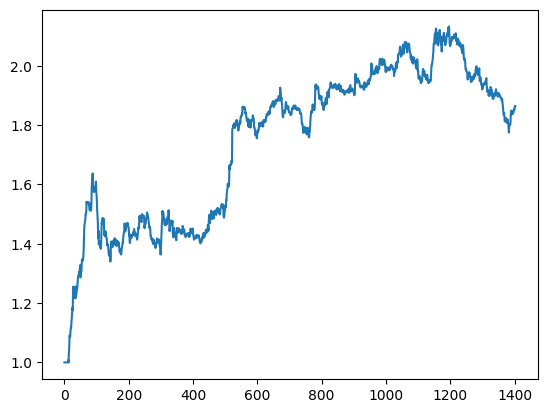

In [41]:
df = pl.read_parquet('../data/1d_alpha101.parquet')


df = df.with_columns(
    (pl.col('returns').abs().rolling_sum(window_size=10)).over('symbol').alias('ret_sum')
)
df = df.with_columns(
    (pl.col('quote_volume').rolling_sum(window_size=10)).over('symbol').alias('volume_sum')
)
df = df.with_columns(
    (pl.col('ret_sum')/pl.col('volume_sum')).over('symbol').alias('amihud_ratio')
)
df = df.with_columns(
    (pl.col('amihud_ratio')+1).log().alias('amihud_ratio')
)

pnl = backtest(df, 'amihud_ratio', long_quantile=0.5, short_quantile=0.5)
pnl = np.cumprod(1 + pnl/100)
plt.plot(pnl)